In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer,confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc
plt.style.use('ggplot')


import sklearn.metrics as metrics

In [68]:
df=pd.read_csv('data/churn_train.csv')

In [3]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [70]:
def clean_churn_data(data):
    
    churn = data.copy()
    
    # fix nan in numeric features
    avg_avg_rating_of_driver = np.mean(churn['avg_rating_of_driver'])
    avg_avg_rating_by_driver = np.mean(churn['avg_rating_by_driver'])
    churn['avg_rating_by_driver'] = churn['avg_rating_by_driver'].apply(
        lambda x: avg_avg_rating_by_driver if np.isnan(x) else x)
    churn['avg_rating_of_driver'] = churn['avg_rating_of_driver'].apply(
        lambda x: avg_avg_rating_of_driver if np.isnan(x) else x)
    
    # remove remaining nan
    churn = churn.dropna()
    
    # convert to datetime
    churn['signup_date'] = pd.to_datetime(churn['signup_date'], format='%Y-%m-%d')
    churn['last_trip_date'] = pd.to_datetime(churn['last_trip_date'], format='%Y-%m-%d')
    
    # convert boolean to int
    churn['luxury_car_user'] = churn['luxury_car_user'].astype(int)
    
    #encode phone to boolean (1 for iphone, 0 for android)
    churn['phone'] = churn['phone'].apply(
        lambda x: 1 if x == 'iPhone' else 0)
    
    #one hot encode city
    churn = pd.get_dummies(churn, columns=['city'], prefix='city', prefix_sep=': ', dtype='int')
    
    # add churn column
    churn_date = datetime.strptime('2014-06-01', '%Y-%m-%d')
    churn['churn?'] = (churn['last_trip_date'] < churn_date).astype(int)
    
    # drop date columns
    churn = churn.drop(columns=['signup_date','last_trip_date'])
    
    return churn

In [71]:
df=clean_churn_data(df)


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Data columns (total 13 columns):
avg_dist                  39681 non-null float64
avg_rating_by_driver      39681 non-null float64
avg_rating_of_driver      39681 non-null float64
avg_surge                 39681 non-null float64
phone                     39681 non-null int64
surge_pct                 39681 non-null float64
trips_in_first_30_days    39681 non-null int64
luxury_car_user           39681 non-null int64
weekday_pct               39681 non-null float64
city: Astapor             39681 non-null int64
city: King's Landing      39681 non-null int64
city: Winterfell          39681 non-null int64
churn?                    39681 non-null int64
dtypes: float64(6), int64(7)
memory usage: 5.5 MB


In [92]:
df['phone']

0        0
1        0
2        1
3        0
4        1
        ..
39995    0
39996    1
39997    0
39998    1
39999    1
Name: phone, Length: 39681, dtype: int64

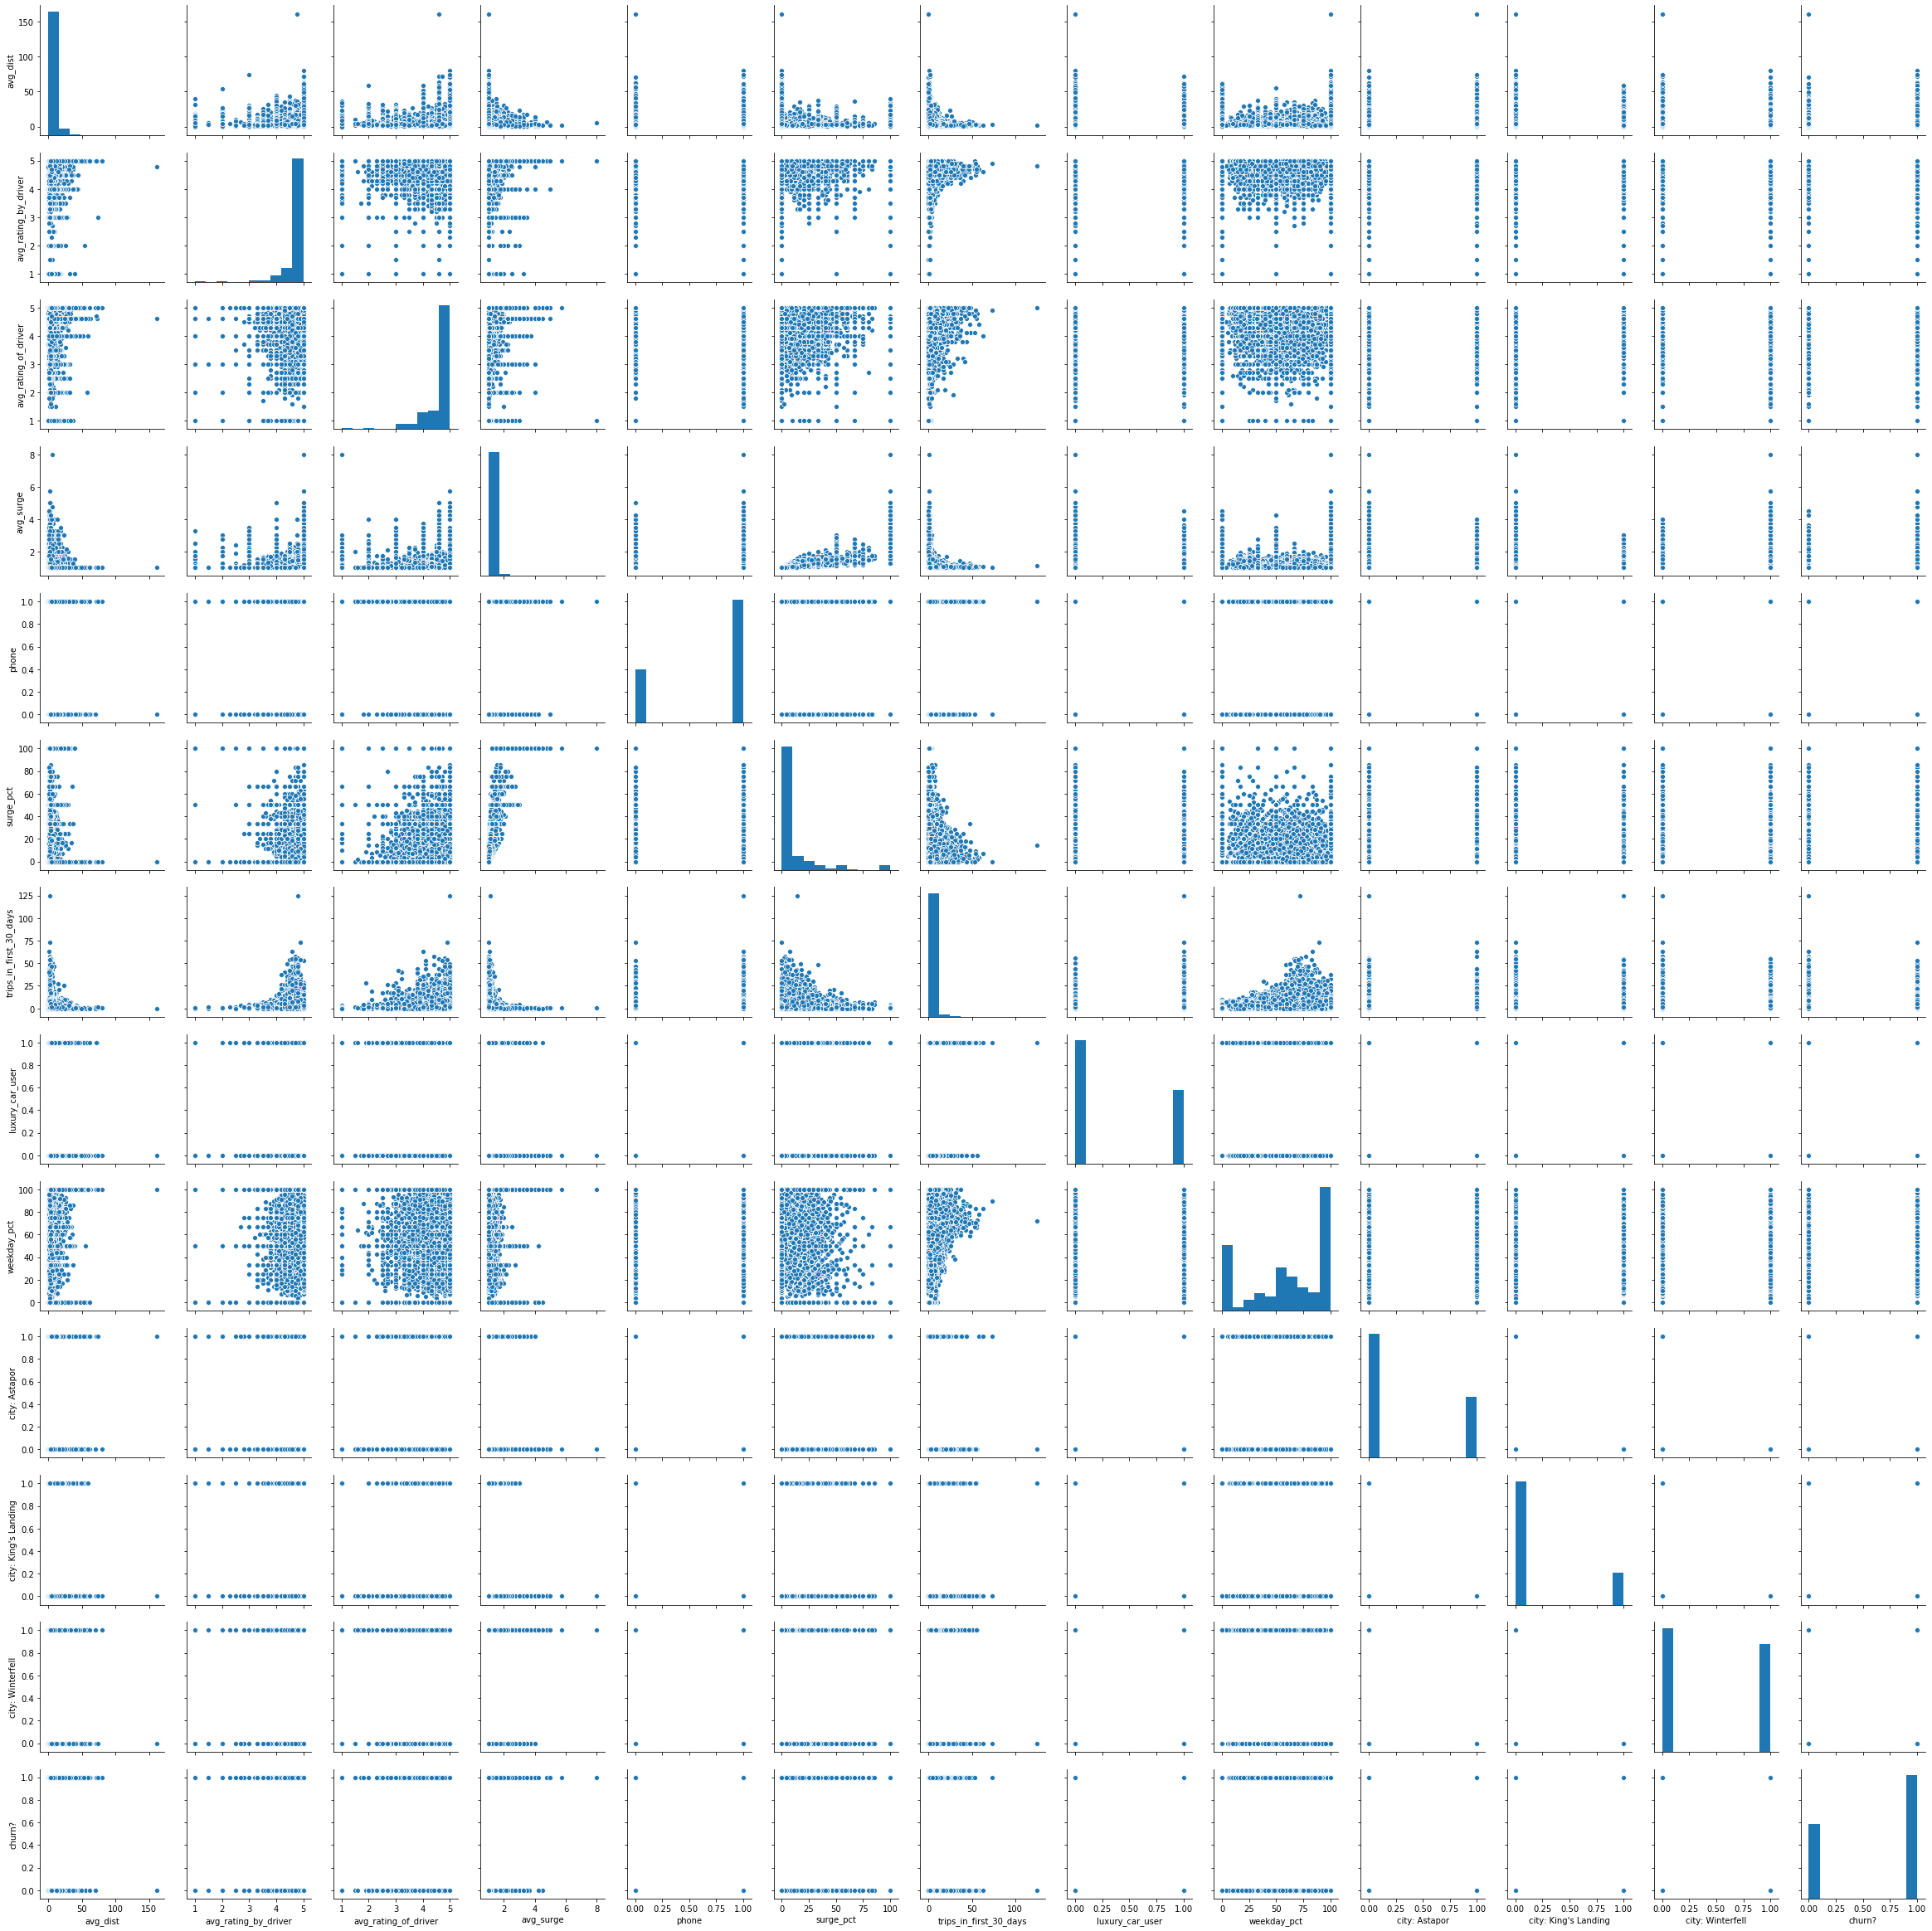

In [73]:
sns.pairplot(df)

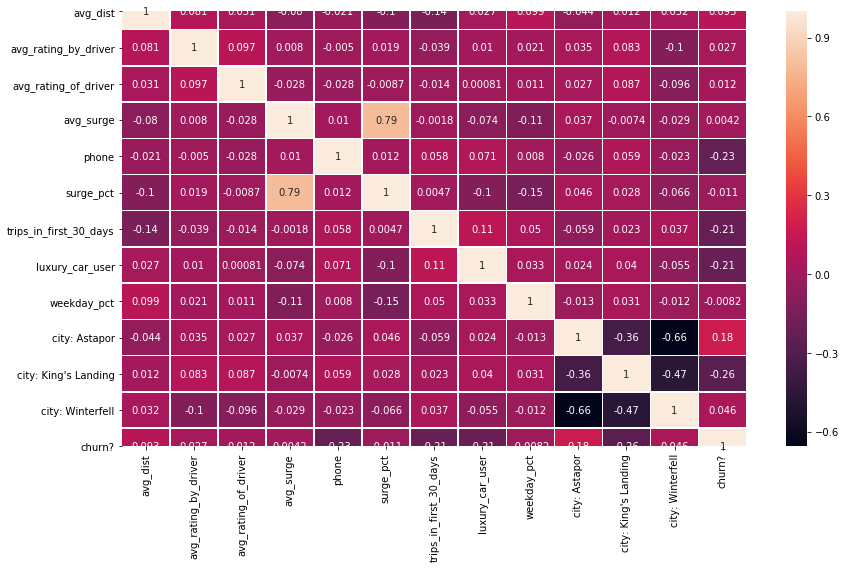

In [88]:

plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True, linewidth=0.5)

In [95]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city: Astapor,city: King's Landing,city: Winterfell,churn?
0,6.94,5.0,5.000000,1.00,0,0.0,0,0,100.0,1,0,0,1
1,8.06,5.0,5.000000,1.00,0,0.0,2,1,0.0,1,0,0,1
2,21.50,4.0,4.601697,1.00,1,0.0,1,1,100.0,0,0,1,1
3,9.46,5.0,4.601697,2.75,0,100.0,1,0,100.0,0,0,1,1
4,13.77,5.0,4.601697,1.00,1,0.0,0,0,100.0,0,0,1,1


In [105]:
y = df['churn?']

In [106]:
X = df.drop('churn?',axis=1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [178]:
# Train and fit model                                                   
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss : {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy : {rf.score(X_test, y_test)}")
print(f"confusion matrix : \n{confusion_matrix(y_test, pred)}")

print("precision :", precision_score(y_test, pred))
print("recall (probability of detection):", recall_score(y_test, pred))

log loss : 1.5802016022232928
accuracy : 0.7432718475960085
confusion matrix : 
[[2566 1172]
 [1375 4808]]
precision : 0.8040133779264214
recall (probability of detection): 0.7776160439915898


## log loss = -(ylog p) + (1-y)*log (1-p))



## Confusion matrix:

<img src="confusion_matrix.png" width="150">

True Positive (TP) : Observation is positive, and is predicted to be positive.
False Negative (FN) : Observation is positive, but is predicted negative.
True Negative (TN) : Observation is negative, and is predicted to be negative.
False Positive (FP) : Observation is negative, but is predicted positive.

## Precision & Recall
<img src="precision-recall.png" width="150">
https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg

In [179]:
# get the feature importances
feature_importances = np.argsort(rf.feature_importances_)
print("top five:", list(df.columns[feature_importances[-1:-6:-1]]))

top five: ['avg_dist', 'weekday_pct', 'avg_rating_by_driver', 'avg_rating_of_driver', 'trips_in_first_30_days']



 Feature ranking: 

1. avg_dist (0.294538)
2. weekday_pct (0.124756)
3. avg_rating_by_driver (0.121537)
4. avg_rating_of_driver (0.086139)
5. trips_in_first_30_days (0.084110)
6. avg_surge (0.069964)
7. surge_pct (0.069027)
8. phone (0.038627)
9. luxury_car_user (0.032205)
10. city: Astapor (0.014008)


Text(0.5, 1.0, 'Feature Importances')

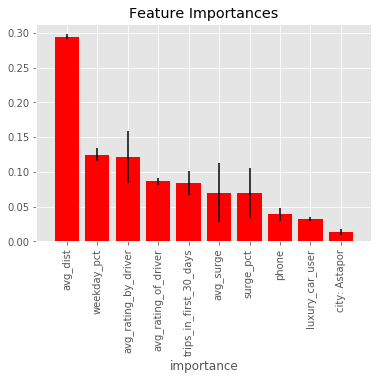

In [180]:
# Calculate the standard deviation for feature importances across all trees

n = 10 # top 10 features

#importances = forest_fit.feature_importances_[:n]
importances = rf.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(df.columns[indices])

# Print the feature ranking
print("\n Feature ranking: \n")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots()

ax.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("importance")
ax.set_title("Feature Importances")

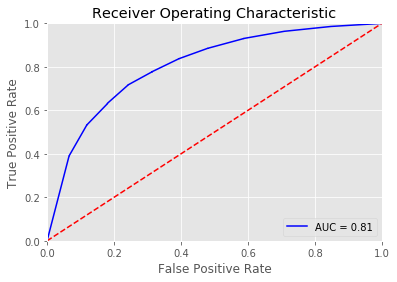

In [181]:

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [141]:
# Building the RandomForestClassifier again setting the out of bag parameter to be true
rf2 = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf2.fit(X_train, y_train)
print("\n11: accuracy score:", rf2.score(X_test, y_test))
print("    out of bag score:", rf2.oob_score_)


11: accuracy score: 0.7546618284447132
    out of bag score: 0.7570228494623656


Text(0.5, 1.0, 'Accuracy vs Num Trees')

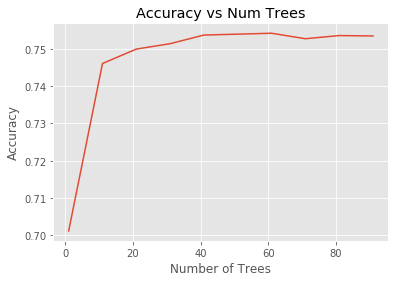

In [182]:
# modifying the number of trees
num_trees = range(1, 100, 10)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')

#max values starting from n_estimators=40 trees

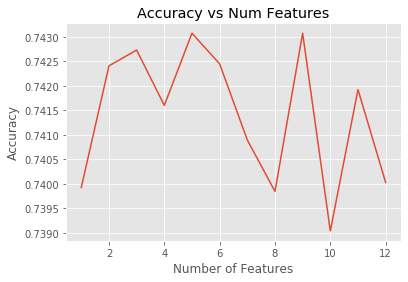

In [150]:
# modifying the max features parameter

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

num_features = range(1, len(df.columns))
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(max_features=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Features');

# maximum at 5 and 9 features

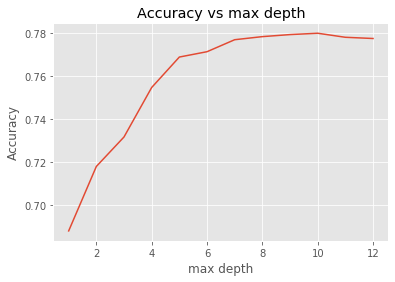

In [187]:
# modifying the max_depth

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

num_features = range(1, len(df.columns))
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(max_depth=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("max depth")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs max depth');

# maximum at max_depth of 10

In [191]:
# Train and fit model (max_depth=10)                                                  
rf = RandomForestClassifier(n_estimators=40,
                           max_features=5,
                           max_depth=10,
                            random_state=0)
model = rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss : {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy : {rf.score(X_test, y_test)}")
print(f"confusion matrix : \n{confusion_matrix(y_test, pred)}")

print("precision :", precision_score(y_test, pred))
print("recall (probability of detection):", recall_score(y_test, pred))

log loss : 0.465862569729533
accuracy : 0.7819776232234654
confusion matrix : 
[[2453 1285]
 [ 878 5305]]
precision : 0.8050075872534143
recall (probability of detection): 0.8579977357269933


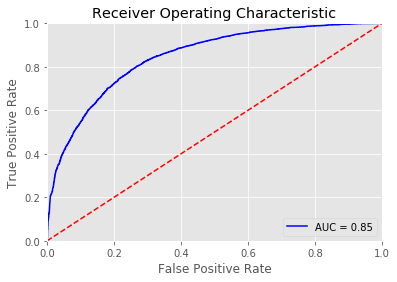

In [192]:

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [89]:
#pd.plotting.scatter_matrix(df);

In [24]:
#df2['last_trip_date']=pd.to_datetime(df2['last_trip_date'])

In [38]:
'''
start_date = '2014-06-01'
end_date = '2014-07-01'
mask = (df2['last_trip_date'] > start_date) & (df2['last_trip_date'] <= end_date)
df2 = df2.loc[mask]
df2
'''

"\nstart_date = '2014-06-01'\nend_date = '2014-07-01'\nmask = (df2['last_trip_date'] > start_date) & (df2['last_trip_date'] <= end_date)\ndf2 = df2.loc[mask]\ndf2\n"

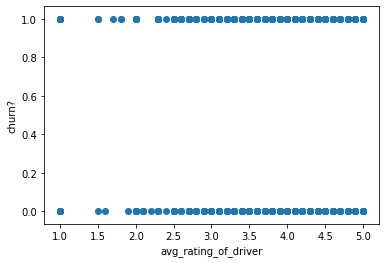

In [65]:
fig,ax = plt.subplots()
def plot(col):
    for i in col:
        ax.scatter(df[col],df['churn?'])
        ax.set_xlabel(i)
        ax.set_ylabel('churn?')
    pass

#col=['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','city','last_trip_date','phone',
    #'surge_pct','trips_in_first_30_days','luxury_car_user','weekday_pct']
col=['avg_rating_of_driver']
plot(col)
                 
   

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB
